In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("YelpDataAnalysisBusiness") \
    .getOrCreate()

# Read JSON files
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

# Convert to Parquet for better performance
business_df.write.parquet("file:///home/dps/Documents/yelp_dataset/Analysis_Milestone1/business.parquet")
review_df.write.parquet("file:///home/dps/Documents/yelp_dataset/Analysis_Milestone1/review.parquet")
user_df.write.parquet("file:///home/dps/Documents/yelp_dataset/Analysis_Milestone1/user.parquet")

# Create temporary views
business_df.createOrReplaceTempView("business")
review_df.createOrReplaceTempView("review")
user_df.createOrReplaceTempView("user")

# Filter for Arizona restaurants
az_restaurants = """
SELECT *
FROM business
WHERE state = 'AZ'
AND categories LIKE '%Restaurants%'
"""
az_rest_df = spark.sql(az_restaurants)
az_rest_df.createOrReplaceTempView("az_restaurants")

24/11/19 20:13:14 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
24/11/19 20:13:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/19 20:13:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/19 20:13:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Query 1: Geographic Distribution of Restaurants

+----------+----------------+----------+-----------+
|      city|restaurant_count|avg_rating|avg_reviews|
+----------+----------------+----------+-----------+
|    Tucson|            2466|      3.46|       97.0|
|Oro Valley|              80|      3.48|      106.0|
+----------+----------------+----------+-----------+



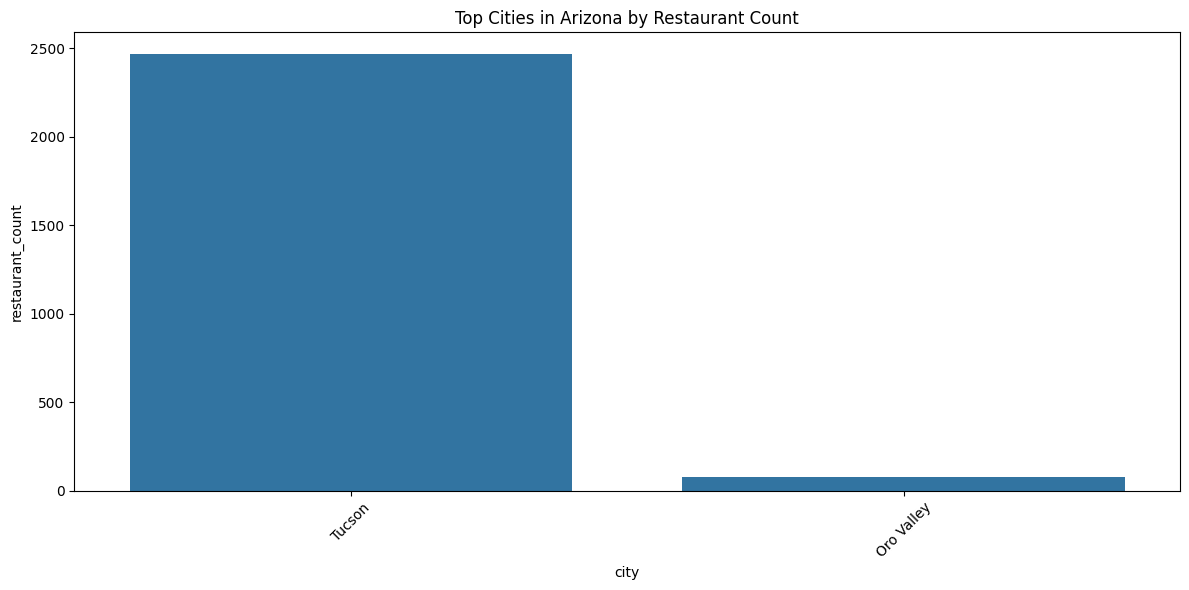

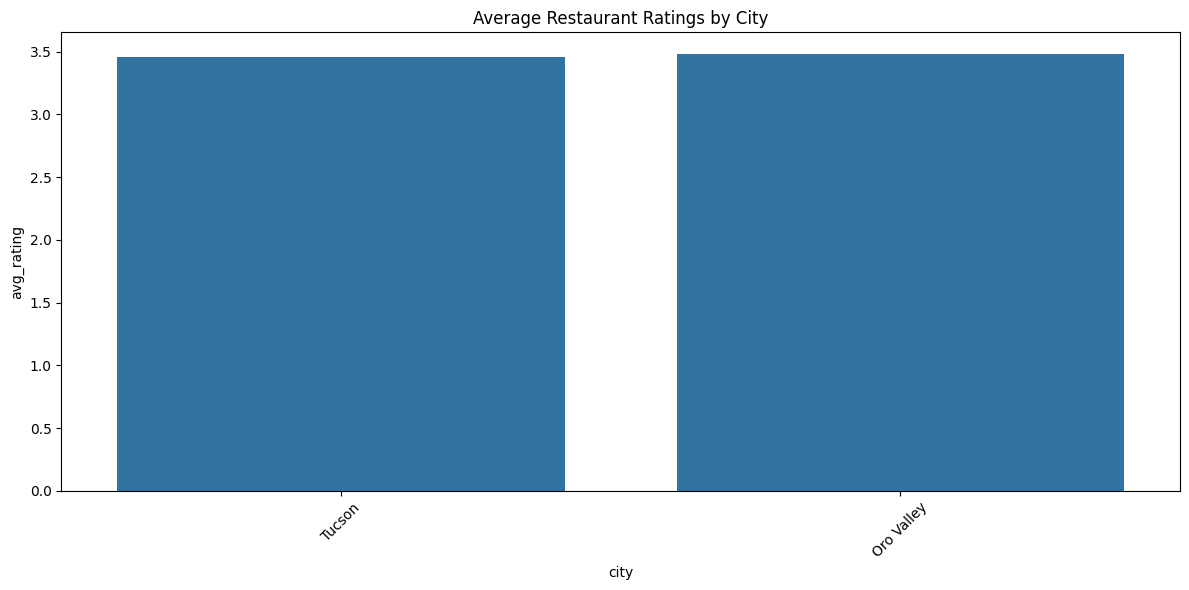

In [2]:
# Analysis of restaurant concentration by city and their average ratings
query1 = """
SELECT 
    city,
    COUNT(*) as restaurant_count,
    ROUND(AVG(stars), 2) as avg_rating,
    ROUND(AVG(review_count), 0) as avg_reviews
FROM az_restaurants
GROUP BY city
HAVING restaurant_count > 50
ORDER BY restaurant_count DESC
LIMIT 10
"""

results1 = spark.sql(query1)
results1.show()

# Visualization
plt.figure(figsize=(12, 6))
data = results1.toPandas()
sns.barplot(x='city', y='restaurant_count', data=data)
plt.title('Top Cities in Arizona by Restaurant Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Second plot for average ratings
plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='avg_rating', data=data)
plt.title('Average Restaurant Ratings by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Query 2: Price Range Analysis

+-----------+----------------+----------+-----------+
|price_range|restaurant_count|avg_rating|avg_reviews|
+-----------+----------------+----------+-----------+
|          1|            1227|      3.28|       57.0|
|          2|            1054|      3.55|      161.0|
|          3|              52|      3.57|      134.0|
|          4|               9|      3.39|      108.0|
|       None|               2|       4.5|       26.0|
+-----------+----------------+----------+-----------+



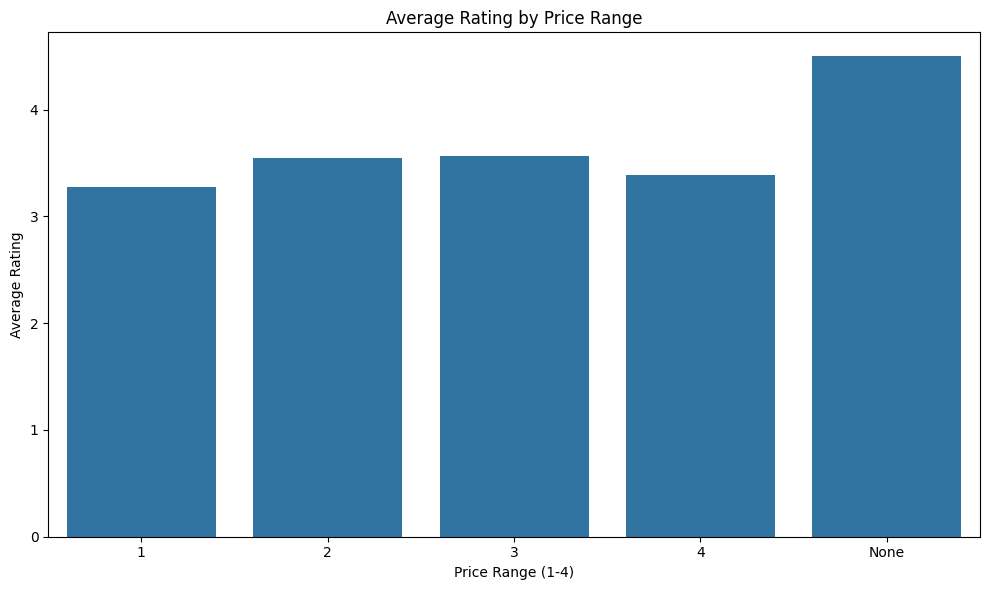

In [3]:
# Analysis of price ranges and their relationship with ratings
query2 = """
SELECT 
    attributes.RestaurantsPriceRange2 as price_range,
    COUNT(*) as restaurant_count,
    ROUND(AVG(stars), 2) as avg_rating,
    ROUND(AVG(review_count), 0) as avg_reviews
FROM az_restaurants
WHERE attributes.RestaurantsPriceRange2 IS NOT NULL
GROUP BY attributes.RestaurantsPriceRange2
ORDER BY price_range
"""

results2 = spark.sql(query2)
results2.show()

# Visualization
plt.figure(figsize=(10, 6))
data = results2.toPandas()
sns.barplot(x='price_range', y='avg_rating', data=data)
plt.title('Average Rating by Price Range')
plt.xlabel('Price Range (1-4)')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

## Query 3: Seasonal Performance Analysis with Price Impact

+------+-----------+---------------+----------------------+-------------------+----------------+
|season|price_range|num_restaurants|avg_reviews_per_season|avg_seasonal_rating|rating_variation|
+------+-----------+---------------+----------------------+-------------------+----------------+
|  Fall|          1|            783|                   6.0|                3.0|             1.3|
|  Fall|          2|            684|                  17.0|               3.63|            0.92|
|  Fall|          3|             28|                  16.0|               3.84|             0.7|
|Spring|          1|            814|                   6.0|               3.09|             1.3|
|Spring|          2|            701|                  19.0|               3.62|            0.87|
|Spring|          3|             28|                  16.0|                3.6|            0.82|
|Summer|          1|            824|                   6.0|               3.02|            1.32|
|Summer|          2|          

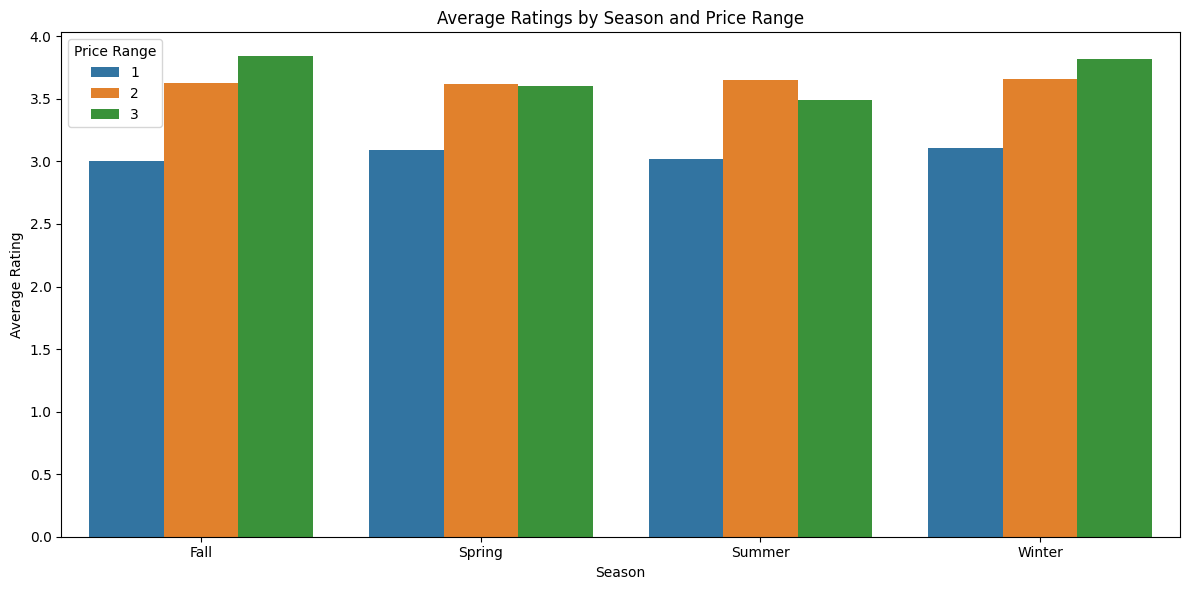

<Figure size 1200x600 with 0 Axes>

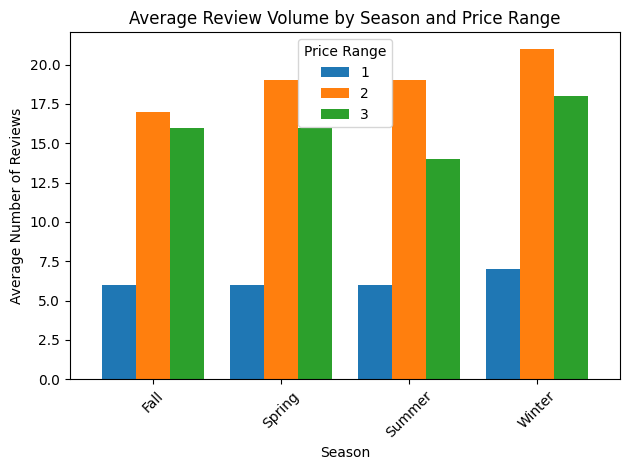

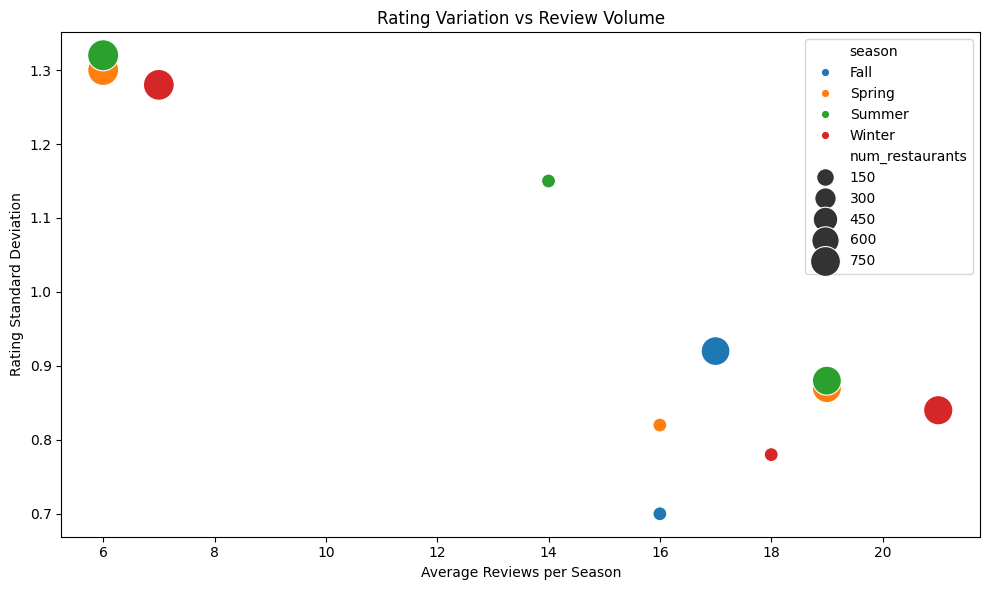

In [4]:
query3 = """
WITH SeasonalMetrics AS (
    SELECT 
        b.business_id,
        b.name,
        b.city,
        b.attributes.RestaurantsPriceRange2 as price_range,
        CASE 
            WHEN MONTH(r.date) IN (6,7,8) THEN 'Summer'
            WHEN MONTH(r.date) IN (9,10,11) THEN 'Fall'
            WHEN MONTH(r.date) IN (12,1,2) THEN 'Winter'
            ELSE 'Spring'
        END as season,
        r.stars as review_rating,
        r.review_id
    FROM az_restaurants b
    JOIN review r ON b.business_id = r.business_id
    WHERE YEAR(r.date) >= 2019
        AND b.attributes.RestaurantsPriceRange2 IS NOT NULL
),

SeasonalPerformance AS (
    SELECT 
        business_id,
        name,
        city,
        price_range,
        season,
        COUNT(review_id) as review_count,
        ROUND(AVG(review_rating), 2) as avg_rating
    FROM SeasonalMetrics
    GROUP BY business_id, name, city, price_range, season
)

SELECT 
    season,
    price_range,
    COUNT(DISTINCT business_id) as num_restaurants,
    ROUND(AVG(review_count), 0) as avg_reviews_per_season,
    ROUND(AVG(avg_rating), 2) as avg_seasonal_rating,
    ROUND(STDDEV(avg_rating), 2) as rating_variation
FROM SeasonalPerformance
GROUP BY season, price_range
HAVING num_restaurants >= 10
ORDER BY season, price_range
"""

results3 = spark.sql(query3)
results3.show()

# Visualization 1: Seasonal Rating Patterns
plt.figure(figsize=(12, 6))
data = results3.toPandas()

sns.barplot(x='season', 
           y='avg_seasonal_rating',
           hue='price_range',
           data=data)
plt.title('Average Ratings by Season and Price Range')
plt.xlabel('Season')
plt.ylabel('Average Rating')
plt.legend(title='Price Range')
plt.tight_layout()
plt.show()

# Visualization 2: Review Volume by Season
plt.figure(figsize=(12, 6))
seasonal_volume = data.pivot(index='season', 
                           columns='price_range', 
                           values='avg_reviews_per_season')
seasonal_volume.plot(kind='bar', width=0.8)
plt.title('Average Review Volume by Season and Price Range')
plt.xlabel('Season')
plt.ylabel('Average Number of Reviews')
plt.legend(title='Price Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 3: Rating Consistency Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data,
                x='avg_reviews_per_season',
                y='rating_variation',
                hue='season',
                size='num_restaurants',
                sizes=(100, 500))
plt.title('Rating Variation vs Review Volume')
plt.xlabel('Average Reviews per Season')
plt.ylabel('Rating Standard Deviation')
plt.tight_layout()
plt.show()

## Query 4: Analysis of Restaurant Success Factors by Operating Hours and Review Patterns 

+---------------+-----------+----------------+-------------------+-----------------+-----------------+----------------+
|service_pattern|price_range|restaurant_count|avg_business_rating|avg_review_rating|avg_active_months|avg_review_count|
+---------------+-----------+----------------+-------------------+-----------------+-----------------+----------------+
|Weekday Service|          2|              43|                4.1|             4.07|              9.8|            62.0|
|Weekday Service|          1|              72|               3.89|              3.8|              9.0|            35.0|
|Weekend Service|          3|              21|               3.74|             3.67|              9.0|            61.0|
|Weekend Service|          2|             580|               3.62|             3.58|             10.2|            74.0|
|Weekend Service|          1|             738|                3.1|             2.95|              7.5|            20.0|
+---------------+-----------+-----------

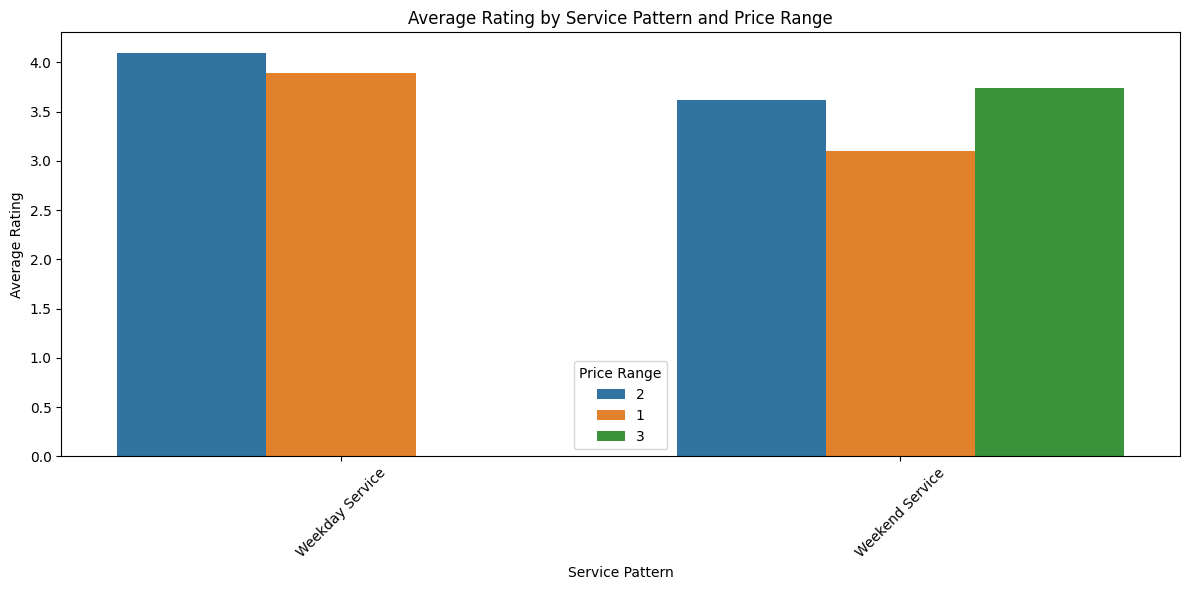

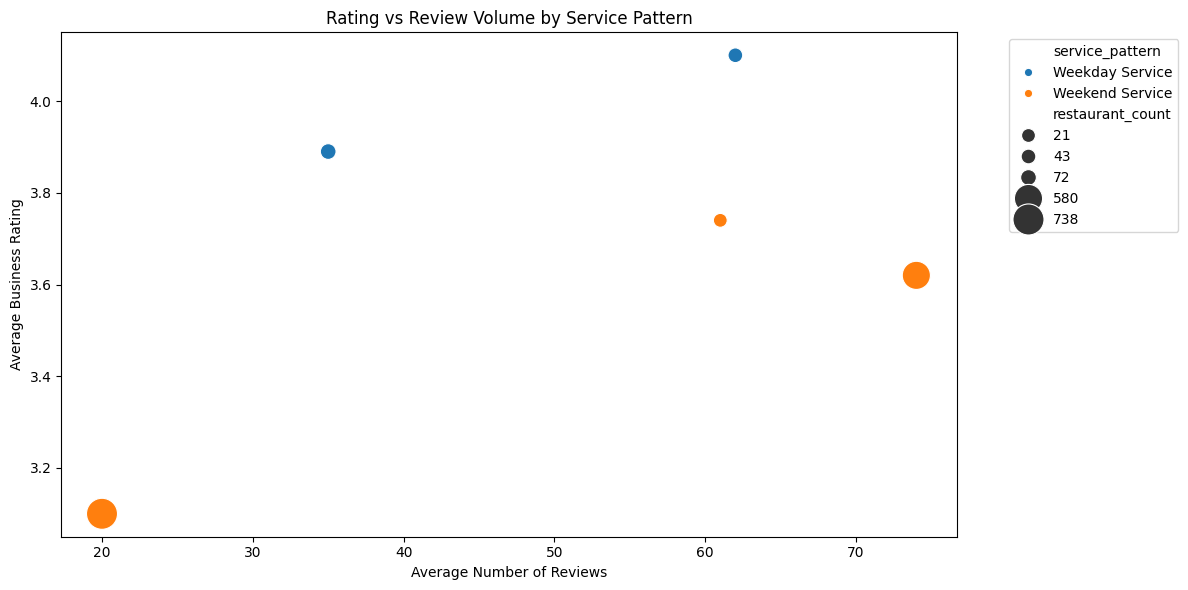

In [5]:
query4 = """
WITH ReviewPatterns AS (
    SELECT 
        b.business_id,
        b.name,
        b.city,
        b.stars as overall_rating,
        COUNT(r.review_id) as total_reviews,
        AVG(r.stars) as avg_review_rating,
        COUNT(DISTINCT EXTRACT(MONTH FROM r.date)) as active_months,
        CASE 
            WHEN hours.Friday IS NOT NULL AND hours.Saturday IS NOT NULL 
                AND hours.Sunday IS NOT NULL THEN 'Weekend Service'
            WHEN hours.Monday IS NOT NULL AND hours.Tuesday IS NOT NULL 
                AND hours.Wednesday IS NOT NULL AND hours.Thursday IS NOT NULL 
                AND hours.Friday IS NOT NULL THEN 'Weekday Service'
            ELSE 'Full Week Service'
        END as service_pattern,
        b.attributes.RestaurantsPriceRange2 as price_range
    FROM az_restaurants b
    JOIN review r ON b.business_id = r.business_id
    WHERE YEAR(r.date) >= 2019
        AND hours.Monday IS NOT NULL  -- Ensuring we have hours data
        AND b.attributes.RestaurantsPriceRange2 IS NOT NULL
    GROUP BY 
        b.business_id, b.name, b.city, b.stars, 
        b.hours.Monday, b.hours.Tuesday, b.hours.Wednesday, 
        b.hours.Thursday, b.hours.Friday, b.hours.Saturday, 
        b.hours.Sunday, b.attributes.RestaurantsPriceRange2
)

SELECT 
    service_pattern,
    price_range,
    COUNT(DISTINCT business_id) as restaurant_count,
    ROUND(AVG(overall_rating), 2) as avg_business_rating,
    ROUND(AVG(avg_review_rating), 2) as avg_review_rating,
    ROUND(AVG(active_months), 1) as avg_active_months,
    ROUND(AVG(total_reviews), 0) as avg_review_count
FROM ReviewPatterns
GROUP BY service_pattern, price_range
HAVING restaurant_count >= 10
ORDER BY avg_business_rating DESC, avg_review_count DESC
"""

results4 = spark.sql(query4)
results4.show()

# Visualization 1: Service Pattern Impact
plt.figure(figsize=(12, 6))
data = results4.toPandas()

sns.barplot(x='service_pattern', 
           y='avg_business_rating',
           hue='price_range',
           data=data)
plt.title('Average Rating by Service Pattern and Price Range')
plt.xlabel('Service Pattern')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.legend(title='Price Range')
plt.tight_layout()
plt.show()

# Visualization 2: Review Engagement Analysis
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data,
                x='avg_review_count',
                y='avg_business_rating',
                hue='service_pattern',
                size='restaurant_count',
                sizes=(100, 500))
plt.title('Rating vs Review Volume by Service Pattern')
plt.xlabel('Average Number of Reviews')
plt.ylabel('Average Business Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Query 5: Comprehensive Success Factor Analysis with Elite Reviews and User Engagement

24/11/19 20:15:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:09 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+----------+--------------+----------------+---------------+-------------+------------+-----------------------+--------------------+-----------------+-----------------+
|cuisine_type|      city|price_category|restaurant_count|business_rating|review_rating|elite_rating|elite_review_percentage|avg_elite_engagement|avg_active_months|avg_total_reviews|
+------------+----------+--------------+----------------+---------------+-------------+------------+-----------------------+--------------------+-----------------+-----------------+
|    American|    Tucson|       Premium|              12|           3.67|         3.63|        3.63|                 100.00|               537.0|             11.8|             71.0|
|       Other|    Tucson|        Budget|             128|           4.01|         3.97|        3.97|                  99.99|               288.0|             11.9|            102.0|
|     Mexican|    Tucson|        Budget|              88|           3.93|         3.89|   

24/11/19 20:15:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/19 20:15:30 WARN RowBasedKeyValueBatch: Calling spill() on

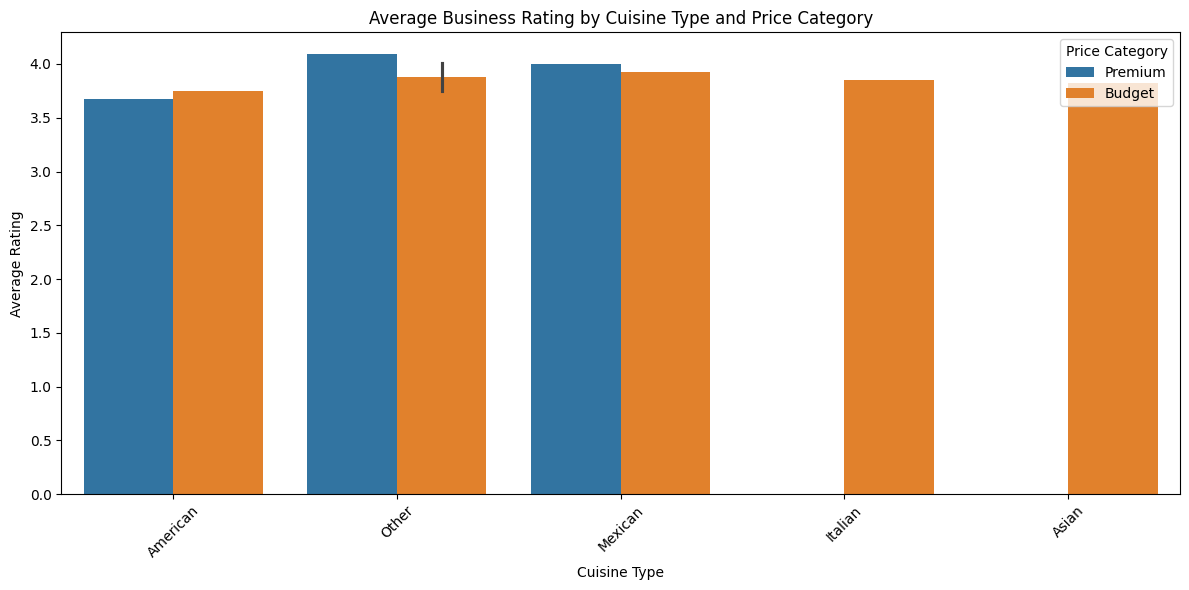

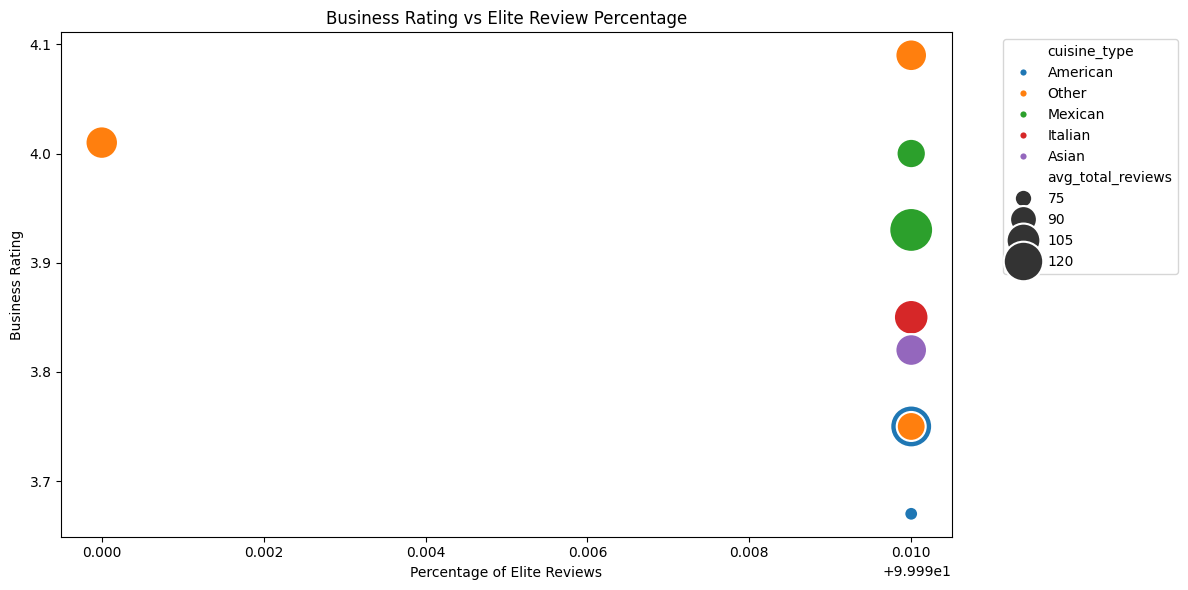

<Figure size 1200x600 with 0 Axes>

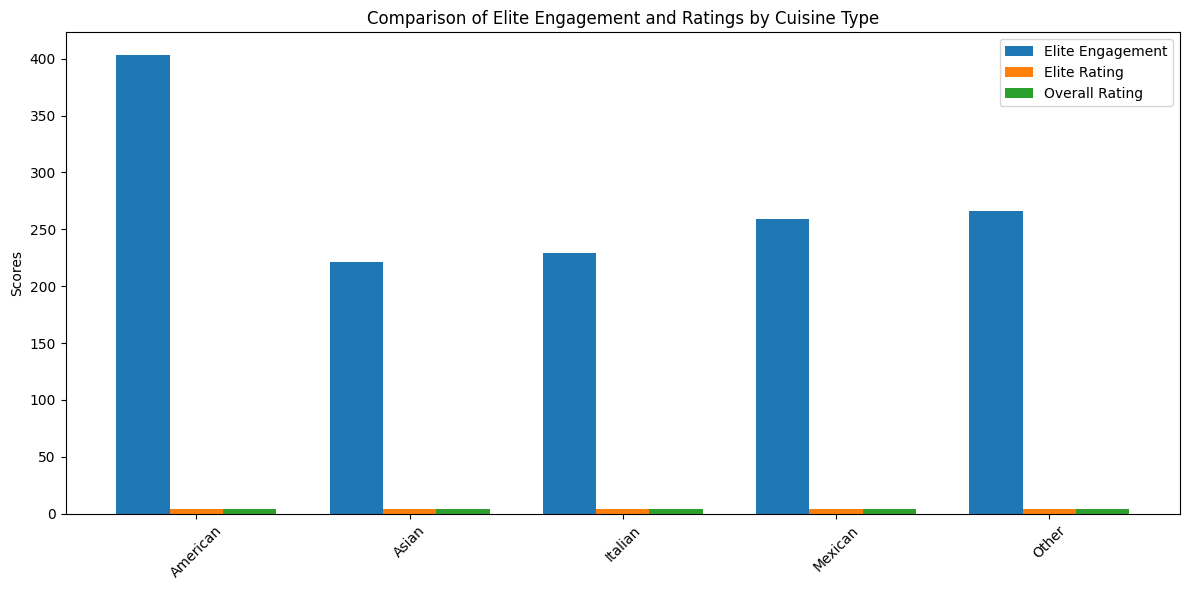

In [6]:
query5 = """
WITH EliteUserStats AS (
    SELECT 
        u.user_id,
        u.review_count as user_review_count,
        u.average_stars as user_avg_rating,
        u.fans,
        u.useful + u.funny + u.cool as total_interactions
    FROM user u
    WHERE u.elite != '[]'
),

ReviewMetrics AS (
    SELECT 
        r.business_id,
        COUNT(DISTINCT CASE WHEN eu.user_id IS NOT NULL THEN r.review_id END) as elite_reviews,
        COUNT(DISTINCT r.review_id) as total_reviews,
        AVG(CASE WHEN eu.user_id IS NOT NULL THEN r.stars END) as elite_rating,
        AVG(r.stars) as avg_rating,
        AVG(CASE WHEN eu.user_id IS NOT NULL THEN eu.total_interactions END) as avg_elite_interactions,
        COUNT(DISTINCT EXTRACT(MONTH FROM r.date)) as active_months
    FROM review r
    LEFT JOIN EliteUserStats eu ON r.user_id = eu.user_id
    WHERE YEAR(r.date) >= 2019
    GROUP BY r.business_id
),

BusinessCategories AS (
    SELECT 
        business_id,
        CASE 
            WHEN categories LIKE '%Mexican%' THEN 'Mexican'
            WHEN categories LIKE '%Italian%' THEN 'Italian'
            WHEN categories LIKE '%American%' THEN 'American'
            WHEN categories LIKE '%Asian%' OR categories LIKE '%Chinese%' 
                 OR categories LIKE '%Japanese%' OR categories LIKE '%Thai%' THEN 'Asian'
            ELSE 'Other'
        END as cuisine_type
    FROM az_restaurants
)

SELECT 
    bc.cuisine_type,
    b.city,
    CASE 
        WHEN b.attributes.RestaurantsPriceRange2 IN ('1', '2') THEN 'Budget'
        ELSE 'Premium'
    END as price_category,
    COUNT(DISTINCT b.business_id) as restaurant_count,
    ROUND(AVG(b.stars), 2) as business_rating,
    ROUND(AVG(rm.avg_rating), 2) as review_rating,
    ROUND(AVG(rm.elite_rating), 2) as elite_rating,
    ROUND(AVG(rm.elite_reviews * 100.0 / rm.total_reviews), 2) as elite_review_percentage,
    ROUND(AVG(rm.avg_elite_interactions), 0) as avg_elite_engagement,
    ROUND(AVG(rm.active_months), 1) as avg_active_months,
    ROUND(AVG(rm.total_reviews), 0) as avg_total_reviews
FROM az_restaurants b
JOIN ReviewMetrics rm ON b.business_id = rm.business_id
JOIN BusinessCategories bc ON b.business_id = bc.business_id
WHERE rm.total_reviews >= 50  -- Ensuring significant review volume
GROUP BY 
    bc.cuisine_type,
    b.city,
    CASE 
        WHEN b.attributes.RestaurantsPriceRange2 IN ('1', '2') THEN 'Budget'
        ELSE 'Premium'
    END
HAVING restaurant_count >= 5  -- Ensuring meaningful sample size
ORDER BY avg_elite_engagement DESC, elite_review_percentage DESC
"""

results5 = spark.sql(query5)
results5.show()

# Visualization 1: Cuisine Type Analysis
plt.figure(figsize=(12, 6))
data = results5.toPandas()

sns.barplot(x='cuisine_type', 
           y='business_rating',
           hue='price_category',
           data=data)
plt.title('Average Business Rating by Cuisine Type and Price Category')
plt.xlabel('Cuisine Type')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.legend(title='Price Category')
plt.tight_layout()
plt.show()

# Visualization 2: Elite Review Impact
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data,
                x='elite_review_percentage',
                y='business_rating',
                hue='cuisine_type',
                size='avg_total_reviews',
                sizes=(100, 1000))
plt.title('Business Rating vs Elite Review Percentage')
plt.xlabel('Percentage of Elite Reviews')
plt.ylabel('Business Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization 3: Elite Engagement Analysis
plt.figure(figsize=(12, 6))
engagement_data = data.groupby('cuisine_type').agg({
    'avg_elite_engagement': 'mean',
    'elite_rating': 'mean',
    'review_rating': 'mean'
}).reset_index()

x = np.arange(len(engagement_data['cuisine_type']))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, engagement_data['avg_elite_engagement'], width, label='Elite Engagement')
ax.bar(x, engagement_data['elite_rating'], width, label='Elite Rating')
ax.bar(x + width, engagement_data['review_rating'], width, label='Overall Rating')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Elite Engagement and Ratings by Cuisine Type')
ax.set_xticks(x)
ax.set_xticklabels(engagement_data['cuisine_type'], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()